# **PHẦN 2: MÔ HÌNH HOÁ DỮ LIỆU**

### **1. Import các packages cần thiết**

In [457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

### **2. Đọc dữ liệu từ file csv**

In [51]:
df = pd.read_csv('./features/processed.csv')
df.shape

(48291, 24)

In [18]:
df.sample(5)

,id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,review_count,inventory_type,productset_group_name,day_ago_created,categories,all_time_quantity_sold,authors,publisher_vn,publication_date,dimensions,manufacturer,number_of_page,dich_gia,edition,luu_y
38260,190155513,3228370393436,Giáo Trình Đo Lường ĐIện,https://tiki.vn/product-p190155513.html?spid=1...,NaN,28000,28000,0,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Khoa Học - ...,117,Sách Khoa Học - Kỹ Thuật,1,NaN,Công ty Cổ Phần Sách Đại Học Dạy Nghề,NaN,NaN,Nhà Xuất Bản Giáo Dục Việt Nam,0,NaN,NaN,NaN
28218,134956715,3716326408199,1001 mẫu câu tiếng Anh giao tiếp thông dụng - ...,https://tiki.vn/product-p134956715.html?spid=1...,Bìa mềm,58000,58000,0,4.8,5,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Học Ngoại N...,401,Sách Học Tiếng Anh,63,NaN,Công ty CP in Thương Mại Nam Hải,NaN,NaN,Nhà Xuất Bản Hà Nội,0,NaN,NaN,NaN
22204,201679853,3423093015421,Làm Chủ Tâm Trí,https://tiki.vn/product-p201679853.html?spid=2...,Bìa mềm,118000,169000,30,0.0,0,instock,Nhà Sách Tiki/Sách tiếng Việt/Sách kỹ năng sốn...,45,Sách tư duy - Kỹ năng sống,4,Michael Nicholas,1980 Books,2022-10-01 00:00:00,"13x20,5cm",Nhà Xuất Bản Dân Trí,360,Thu Trang,NaN,NaN
37864,198482833,3669205407845,Giáo Trình Kỹ Nghệ Phần Mềm,https://tiki.vn/product-p198482833.html?spid=1...,NaN,36000,36000,0,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Khoa Học - ...,68,Sách Khoa Học - Kỹ Thuật,3,NaN,Công ty Cổ Phần Sách Đại Học Dạy Nghề,NaN,NaN,Nhà Xuất Bản Giáo Dục Việt Nam,0,NaN,NaN,NaN
16769,191923876,6013161875582,Bách Khoa Thư Kĩ Năng Sống - Dành Cho Bạn Trai...,https://tiki.vn/product-p191923876.html?spid=1...,Bìa mềm,59900,75000,20,5.0,1,instock,Nhà Sách Tiki/Sách tiếng Việt/Sách thiếu nhi /...,135,Kiến thức - Bách khoa,17,Peng Fan,Nhà Xuất Bản Kim Đồng,2022-07-07 00:00:00,"14,5 x 20,5 cm",Nhà Xuất Bản Kim Đồng,176,Thanh Vân,NaN,NaN


### **3. Xác định câu hỏi cần trả lời:**
- Bài toán dự đoán `discount_rate` dựa trên các đặc trưng.
- Đây là một bài toán hồi quy.
- Input là các đặc trưng ảnh hưởng đến tỉ lệ giảm giá của một mặt hàng sách.
- Output là tỉ lệ giảm giá của sách. 

Trả lời được câu hỏi này sẽ giúp cho khách hàng và nhà bán có những quyết định phù hợp, mang lại lợi ích 

### **4. Phân tích, xử lý và chuẩn bị dữ liệu cho bước mô hình hoá**

Các cột có kiểu dữ liệu là numeric 

In [20]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols

Index(['id', 'sku', 'price', 'original_price', 'discount_rate',
       'rating_average', 'review_count', 'day_ago_created',
       'all_time_quantity_sold', 'number_of_page'],
      dtype='object')

In [21]:
numeric_profiles = {'missing_ratio': df[numeric_cols].isna().sum() * 100.0/len(df[numeric_cols]),
                        'min': df[numeric_cols].min(),
                        'max': df[numeric_cols].max()}
nume_col_profiles_df = pd.DataFrame(numeric_profiles).transpose()
nume_col_profiles_df

,id,sku,price,original_price,discount_rate,rating_average,review_count,day_ago_created,all_time_quantity_sold,number_of_page
missing_ratio,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
min,148562.0,1.000110e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
max,207990688.0,9.999995e+12,6000000.0,6950000.0,91.0,5.0,6306.0,2689.0,32323.0,9.786049e+12


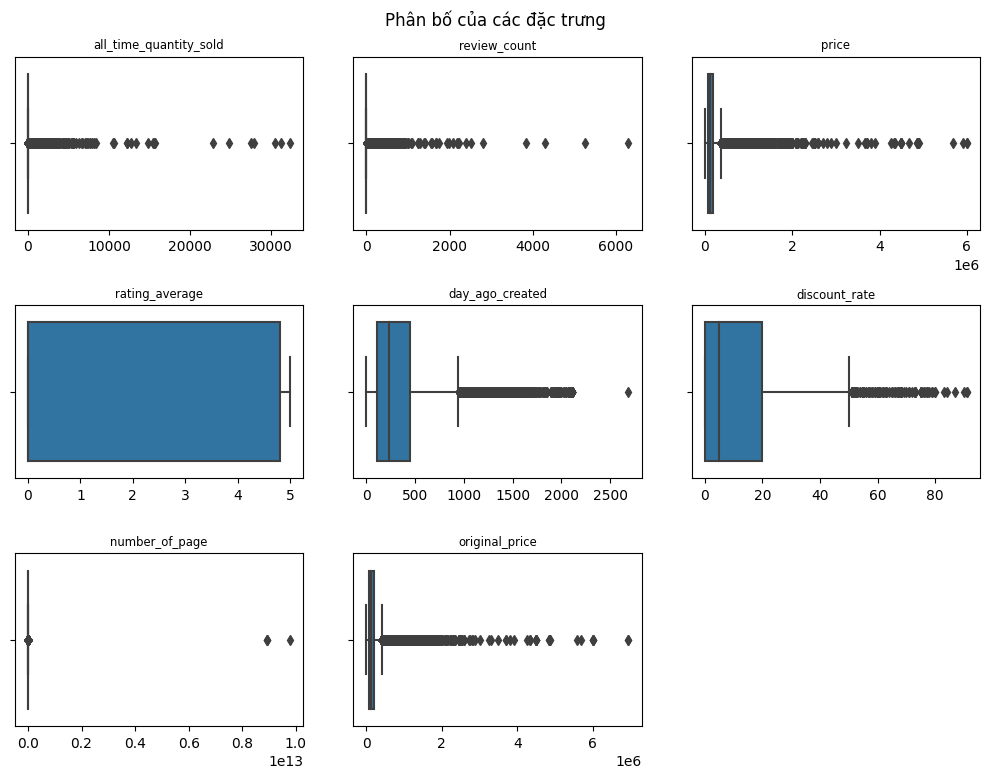

In [456]:
# df_cont = df.select_dtypes([int,float]) 
numeric_df = df[set(numeric_cols) - {'id', 'sku'}]

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Phân bố của các đặc trưng')
for i,col in enumerate(numeric_df.columns, 1): 
    ax = plt.subplot(4,3,i) 
    sns.boxplot(data = numeric_df, x=numeric_df[col]) 
    plt.xlabel(None)
    plt.title(col, fontsize='small')
    plt.tight_layout(w_pad=3) 

plt.show() 

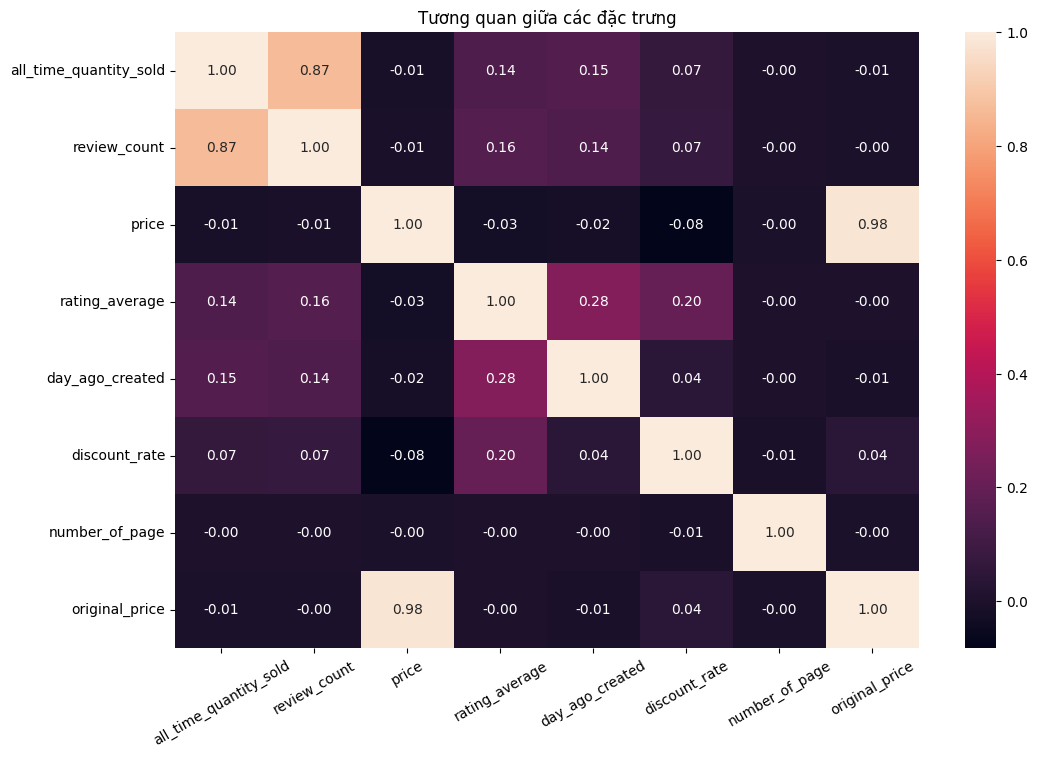

In [445]:
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f')
plt.xticks(rotation=30)
plt.title('Tương quan giữa các đặc trưng')
plt.show()

In [22]:
cate_cols = set(df.columns) - set(numeric_cols)
cate_profiles = {'missing_ratio': df[cate_cols].isna().sum() * 100.0/len(df[cate_cols]),
               #   'zero_values_ratio':  df[cate_cols].eq(0).sum(axis=1) * 100.0/len(df[cate_cols]),
                      'num_diff_vals': df[cate_cols].nunique(dropna=True),
                      'diff_vals': df[cate_cols].stack(dropna=True).groupby(level=[1]).unique()}
cate_col_profiles_df = pd.DataFrame(cate_profiles).transpose()
cate_col_profiles_df

,authors,book_cover,categories,dich_gia,dimensions,edition,inventory_type,luu_y,manufacturer,name,productset_group_name,publication_date,publisher_vn,short_url
missing_ratio,48.804125,35.358555,0.0,85.686774,82.744197,96.931105,0.0,99.995858,0.550827,0.0,0.0,61.158394,0.035203,0.0
num_diff_vals,9094,17,100,3110,1051,364,3,1,168,44424,101,10896,852,48288
diff_vals,"[Trần Đặng Đăng Khoa, Trần Hồng Ngọc, Lê Quang...","[Bìa mềm, Bìa Da, Bìa cứng, Bìa gập, Bìa rời, ...","[Du ký, Light novel, Phê Bình - Lý Luận Văn Họ...","[Khánh Vân, Phan Quang, Nguyễn Thị Bạch Tuyết,...","[13 x 20, 14,5 x 20,5 cm, 13.5 x 20.5 cm, 15 x...","[bìa mềm, BÌA MỀM, Tiếng Việt, Tặng kèm bookma...","[instock, backorder, preorder]",[Sách không còn kèm CD mà thay bằng ứng dụng t...,"[NXB Trẻ, Nhà Xuất Bản Lao Động, Nhà Xuất Bản ...",[1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàn...,[Nhà Sách Tiki/Sách tiếng Việt/Sách văn học/Du...,"[2022-11-10 00:00:00, 2022-11-11 17:44:46, 202...","[NXB Trẻ, Chibooks, Văn Lang, Edibooks, NXB Ph...",[https://tiki.vn/product-p204317934.html?spid=...


In [325]:
df['dimensions'][df['dimensions'].str.contains('(\d+).?[xX].?(\d+).?[(cm)(CM)]?', na=False)].loc[1100]

'13x18x2.5 cm'

In [436]:
df['dimensions'].str.extractall('(\d+[.,]?\d+.?.?[xX]?.?.?\d+[.,]?\d+)').loc[39592]
df['dimensions'].str.extractall(r'(\d+.?,?\d+).?x.?(\d+.?,?\d+)[.?x.?(\d+.?,?\d+)]?')#['dimensions']

,0
match,
0,15 x 23.5


In [368]:
dimen = pd.DataFrame(df['dimensions'][df['dimensions'].notna()].str.replace('[a-zA-Z]', ' ').str.replace(',', '.').str.split())
# dimen['area'] = dimen['dimensions'].apply(lambda x: list(map(float, x))).apply(lambda x: np.prod(x))
dimen.loc[39592]

dimensions    [<, =", /, "><!--, {, :, 1, #, ;}, {, -, -, :,...
Name: 39592, dtype: object

In [441]:
cate_col_profiles_df.loc['diff_vals', 'manufacturere']

array(['NXB Trẻ', 'Chibooks', 'Văn Lang', 'Edibooks',
       'NXB Phụ Nữ Việt Nam', 'Nhã Nam', 'Bloom Books',
       'Nhà Xuất Bản Đại Học Quốc Gia Hà Nội',
       'Nhà Xuất Bản Văn hóa Văn nghệ', 'Tân Việt',
       'Công Ty Cổ Phần Văn Hóa Đông A', 'NXB Tổng Hợp', 'FlyBooks',
       'NXB Phụ Nữ', 'Alpha Books', 'First News - Trí Việt',
       'Cty Văn Hóa Văn Lang', 'NXB Tổng Hợp TP. HCM', 'Bách Việt',
       'Đinh Tị', 'Thái Hà', 'Công ty TNHH Thư Books', 'NXB Tư Pháp',
       'Nhà Xuất Bản Văn Hóa - Văn Nghệ', 'Sách điện tử Bách Việt',
       'SBOOKS', 'Huy Hoàng Bookstore', 'NXB Tri Thức', 'Skybooks',
       'Nhã Nam -  Hội Nhà Văn', 'Nhã Nam ', 'oem',
       'Nhà Xuất Bản Kim Đồng',
       'Công Ty TNHH Văn Hóa và Truyền Thông AZ Việt Nam', 'THBooks',
       'Công Ty TNHH Văn Hóa Đông Tây', 'Cty Bán Lẻ Phương Nam',
       '1980 Books', 'IPM', 'Skynovel', 'USAGI LIGHT NOVEL',
       'Wings Books', 'AZ Việt Nam', 'Tsuki LightNovel', 'NXB Kim Đồng',
       'Shinebooks', 'Ai Novel', '

Chọn ra các features phù hợp/ có ảnh hưởng đến yêu cầu bài toán làm đầu vào cho mô hình 

In [442]:
cols = ['original_price', 'discount_rate',
       'rating_average', 'review_count', 'day_ago_created',
       'all_time_quantity_sold', 'number_of_page']
# Thêm một vài cột categories có ý nghĩa đối với output
cols.extend(['book_cover', 'categories', 'inventory_type', 'manufacturer', 'publication_date'])

Xem qua kiểu dữ liệu của các cột

In [458]:
df[cols].dtypes

original_price              int64
discount_rate               int64
rating_average            float64
review_count                int64
day_ago_created             int64
all_time_quantity_sold      int64
number_of_page              int64
book_cover                 object
categories                 object
inventory_type             object
manufacturer               object
publication_date           object
dtype: object

In [461]:
df[['categories', 'inventory_type', 'manufacturer']] = df[['categories', 'inventory_type', 'manufacturer']].astype(str)
df[['categories', 'inventory_type', 'manufacturer']]

,categories,inventory_type,manufacturer
0,Du ký,instock,NXB Trẻ
1,Du ký,backorder,NXB Trẻ
2,Du ký,instock,Nhà Xuất Bản Lao Động
3,Du ký,backorder,Nhà Xuất Bản Hồng Đức
4,Du ký,backorder,NXB Trẻ
...,...,...,...
48286,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Hà Nội
48287,Thể Dục - Thể Thao,backorder,NXB Trẻ
48288,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Đại Học Quốc Gia Hà Nội
48289,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Thể Thao Và Du Lịch


**Các cột có giá trị thiếu hay không? Nếu thiếu thì xử lý như thế nào?**

In [444]:
df[cols].isna().sum()

original_price                0
discount_rate                 0
rating_average                0
review_count                  0
day_ago_created               0
all_time_quantity_sold        0
number_of_page                0
book_cover                17075
categories                    0
inventory_type                0
manufacturer                266
publication_date          29534
dtype: int64

Cột `publication_date` đang có kiểu dữ liệu là 

In [ ]:
df[df['publication_date']]